In [37]:
import numpy as np
import pandas as pd

from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
                                     Conv2DTranspose, concatenate)

from tensorflow.keras.models import Model

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Можете взять один из этих наборов данных:  
https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset

In [4]:
PATH_TO_IMG = 'segmentation_full_body_mads_dataset_1192_img/images'
PATH_TO_MASK = 'segmentation_full_body_mads_dataset_1192_img/masks'

In [9]:
images_paths = list(Path(PATH_TO_IMG).iterdir())
masks_paths = list(Path(PATH_TO_MASK).iterdir())

In [10]:
images = []
masks = []

image_size = (512, 384)

In [11]:
for i_image, i_mask in zip(images_paths, masks_paths):
    
    image_from = image.load_img(i_image, target_size=image_size)
    mask_from = image.load_img(i_mask, target_size=image_size)
    
    images.append(image_from)
    masks.append(mask_from)

In [12]:
import matplotlib.pyplot as plt

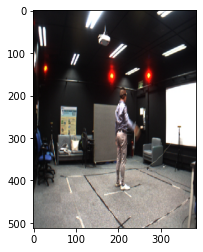

In [16]:
plt.imshow(images[0].convert('RGBA'))

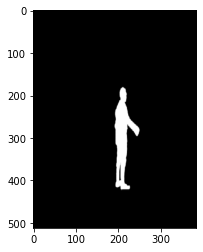

In [17]:
plt.imshow(masks[0].convert('RGBA'))

In [18]:
X = []

for img in images:
    x = image.img_to_array(img)
    X.append(x)
    
X = np.array(X)

In [19]:
X.shape

(1192, 512, 384, 3)

Human(255,255,255)  
background(0,0,0)

In [20]:
def color_to_index(y):
    colors_array = [
        [255, 255, 255],
        [0, 0, 0]
    ]
    
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(colors_array)))
    
    i = 1
    
    for i_color in colors_array:
        ind_i = np.where(
            (y[..., 0] == i_color[0])
            & (y[..., 1] == i_color[1])
            & (y[..., 2] == i_color[2])
        )
        
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1
        
        i += 1
        
    return y_cat, y_ind

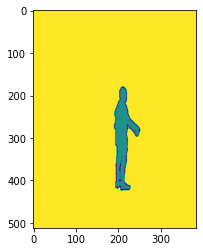

In [21]:
cat_yi, ind_yi = color_to_index(image.img_to_array(masks[0]))
plt.imshow(ind_yi)
plt.show()

In [22]:
ind_yi

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

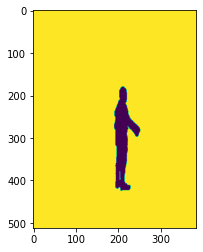

In [26]:
plt.imshow(cat_yi[..., 1])

In [27]:
cat_yi.shape

(512, 384, 2)

In [28]:
y = []

for mask in masks:
    y_cat, _ = color_to_index(image.img_to_array(mask))
    y.append(y_cat)

y = np.array(y)

In [29]:
y.shape

(1192, 512, 384, 2)

In [31]:
n = int(y.shape[0] * 0.7)

X_train = X[:n, ...]
y_train = y[:n, ...]

X_test = X[n:, ...]
y_test = y[n:, ...]

In [34]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [51]:
def u_net(num_classes=2, input_shape=(512, 384, 3)):
    
    img_input = Input(input_shape)
    
    # block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_1_out)
    
    # block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_2_out)
    
    # block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_3_out)
    
    # block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)
    
    # up 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # up 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # up 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
    
    model = Model(img_input, x)
    
    return model

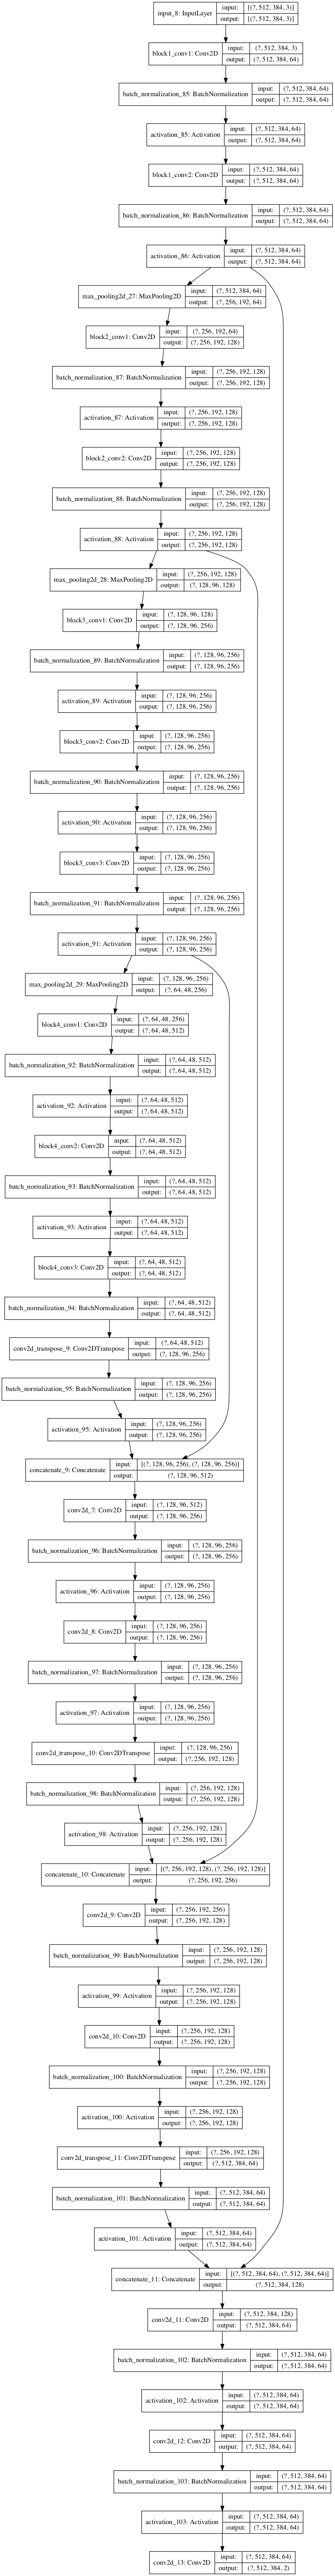

In [52]:
model_unet = u_net(2, (512, 384, 3))

keras.utils.plot_model(model_unet, to_file='model_unet.png', show_shapes=True)

In [53]:
model_unet.compile(optimizer=keras.optimizers.Adam(), 
                   loss='categorical_crossentropy', 
                   metrics=[dice_coef])
model_unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 384, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 512, 384, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_85 (Activation)      (None, 512, 384, 64) 0           batch_normalization_85[0][0]     
_______________________________________________________________________________________

In [54]:
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [55]:
history = model_unet.fit(X_train, y_train, 
          epochs=20, 
          batch_size=1, 
          validation_data=(X_test, y_test), 
          callbacks=[DisplayCallback(patience=5)])

Epoch 1/20
  1/834 [..............................] - ETA: 1s - loss: 0.8918 - dice_coef: 0.4518

KeyboardInterrupt: 

2. Опишите в комментарии - какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?